In [1]:
%matplotlib inline
import torch
import os,sys
import numpy as np
import torchvision.io as io
import matplotlib.pyplot as plt
import matplotlib.image as mpimg 
import torchvision.transforms.functional as TF
from torch.utils.data import Dataset, random_split, DataLoader
%load_ext autoreload
%autoreload 2

# *Set up environment* 

In [2]:
torch.manual_seed(202042)
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
print(device)

cuda


In [3]:
if "google.colab" in sys.modules:
    from google.colab import drive
    drive.mount('/content/drive', force_remount=True, use_metadata_server=False)

Mounted at /content/drive


In [4]:
def import_file(url, filename):
  import requests
  r = requests.get(url)

  with open(filename, 'w') as f:
        f.write(r.text)

if "google.colab" in sys.modules:
    # Save datagenerators as file to colab working directory
    # If you are using GitHub, make sure you get the "Raw" version of the code
    url_u_net = 'https://raw.githubusercontent.com/karimassi/road-segmentation/main/src/models/u_net.py?token=AH35XEZLG77J44LJEI3JUA273MJ3Y'
    import_file(url_u_net, 'u_net.py')

    url_u_net_paper = 'https://raw.githubusercontent.com/karimassi/road-segmentation/main/src/models/u_net_paper.py?token=AH35XE3C7J2MEAJUDPPB7NS73MJ44'
    import_file(url_u_net_paper, 'u_net_paper.py')

    url_training = 'https://raw.githubusercontent.com/karimassi/road-segmentation/main/src/training.py?token=AH35XE4C3I6GA76R5S52S6K73MJ6O'
    import_file(url_training, 'training.py')

    url_image_mask_dataset = "https://raw.githubusercontent.com/karimassi/road-segmentation/main/src/image_mask_dataset.py?token=AH35XEZ6S76B5H677BWENH273MJ7O"
    import_file(url_image_mask_dataset, 'image_mask_dataset.py')

    url_losses = "https://raw.githubusercontent.com/karimassi/road-segmentation/main/src/losses.py?token=AH35XE7IQIBGM4BD6Y5WKC273MKA2"
    import_file(url_losses, 'losses.py')

    url_mask_to_submission = "https://raw.githubusercontent.com/karimassi/road-segmentation/main/src/scripts/mask_to_submission.py?token=AH35XE4CSULUVJL4W77YT3S73MKCE"
    import_file(url_mask_to_submission, 'mask_to_submission.py')

    url_helpers = "https://raw.githubusercontent.com/karimassi/road-segmentation/main/src/scripts/helpers.py?token=AH35XE6XSPSCRLSVMFJL7JS73MKES"
    import_file(url_helpers, 'helpers.py')
        
    import u_net
    import u_net_paper 
    import training
    import image_mask_dataset
    import losses
    from mask_to_submission import masks_to_submission
    import helpers
else:
    from src import u_net
    from src import u_net_paper
    from src import training
    from src import image_mask_dataset
    from src import losses
    from src import helpers

# **Load data**

In [5]:
# load data
from image_mask_dataset import ImageMaskDataset

root_dir = "/content/drive/Shareddrives/road-segmentation/data/"
image_dir = root_dir + "training/images/"
gt_dir = root_dir + "training/groundtruth/"
test_dir = root_dir + "test_set_images/"

dataset = ImageMaskDataset(image_dir, gt_dir)

# data augmentation
angles = [15, -10, 45, -60, 78]
for angle in angles:
    rotation = lambda img: TF.rotate(img, angle)
    dataset += ImageMaskDataset(image_dir, gt_dir, rotation)

shears = [[15, 20], [10, 30], [30, -17], [-3, 20], [-5, -10]]
for shear in shears:
  transformation = lambda img: TF.affine(img, angle=0, scale=1.0, translate=[0, 0], shear=shear)
  dataset += ImageMaskDataset(image_dir, gt_dir, transformation)

print(len(dataset))

9900


In [6]:
batch_size = 5

data_len = len(dataset)
train_len = int(data_len * 0.8)
test_len = int(data_len * 0.2)

dataset_train, dataset_test = random_split(dataset, [train_len, test_len])
print(len(dataset_train), len(dataset_test))

dataloader_train = torch.utils.data.DataLoader(
    dataset_train,
    batch_size=batch_size,
    shuffle=True
)

dataloader_test = torch.utils.data.DataLoader(
    dataset_test,
    batch_size=batch_size,
    shuffle=True
)

7920 1980


# ***Learning Rate Finder***

In [15]:
!pip install torch-lr-finder

Stopping early, the loss has diverged
Learning rate search finished. See the graph with {finder_name}.plot()
LR suggestion: steepest gradient
Suggested LR: 2.31E-04



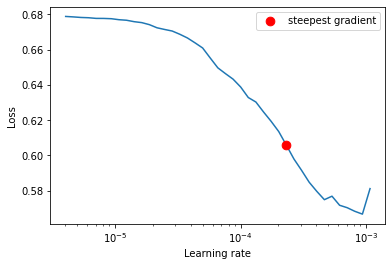

In [18]:
from torch_lr_finder import LRFinder
from u_net_paper import UNet_paper

NUM_CHANNELS = 3
NUM_FILTERS = 64

model = UNet_paper(NUM_CHANNELS, NUM_FILTERS).to(device)

criterion = torch.nn.BCELoss()
optimizer = torch.optim.Adam(model.parameters(), lr=1e-6)

lr_finder = LRFinder(model, optimizer, criterion, device="cuda")
lr_finder.range_test(dataloader_train, end_lr=1, num_iter=100)
lr_finder.plot() # to inspect the loss-learning rate graph
lr_finder.reset() # to reset the model and optimizer to their initial state

# ***Train model***

In [20]:
#@title Setup
# Name of the run:
run_name = "Unet_paper_Adam_BCE"   #@param {type:"string"}
# Path to the drive:
drive_path = "/content/drive/Shareddrives/road-segmentation/"   #@param {type:"string"}
# Stating epoch (if not 0 load model):
starting_epoch = 0   #@param {type:"integer",  min:0}
# Epoch step (number of epoch between each save):
epoch_step = 10   #@param {type:"integer",  min:1}
# Number of training Epoch
total_iterations = 50    #@param {type:"integer", min:1}
# Learning rate (please run above cell and use best found):
learning_rate = 1e-4 #@param {type:"number", min:1e-6}


In [21]:
from u_net_paper import UNet_paper

NUM_CHANNELS = 3
NUM_FILTERS = 64

#decay_rate = 0.95

model = UNet_paper(NUM_CHANNELS, NUM_FILTERS).to(device)
optimizer = torch.optim.Adam(model.parameters(), lr=learning_rate)
#scheduler = torch.optim.lr_scheduler.ExponentialLR(optimizer=optimizer, gamma=decay_rate, verbose=True)


criterion = torch.nn.BCELoss()


if starting_epoch > 0:
    loading_model_file = run_name + f"_{starting_epoch}.pkt"

    if loading_model_file in os.listdir(drive_path):
        print("Loading model from " + loading_model_file)
        state_dicts = torch.load(drive_path + loading_model_file)
        model.load_state_dict(state_dicts['model_state_dict'])
        optimizer.load_state_dict(state_dicts['optimizer_state_dict'])
        #scheduler.load_state_dict(state_dicts['scheduler_state_dict"])
    else :
      print("Unable to load model from " + loading_model_file)

#from torchsummary import summary
#summary(model, input_size=(NUM_CHANNELS, 400, 400))

In [10]:
import training

for i in range(starting_epoch, total_iterations, epoch_step):
    accuracies, f1_scores, iou_scores = training.train(model, criterion, dataloader_train, dataloader_test, optimizer, num_epochs=num_epochs)

    torch.save(
        {
          'model_state_dict': model.state_dict(),
          #'scheduler_state_dict': scheduler.state_dict(),
          'optimizer_state_dict': optimizer.state_dict()
        },
        drive_path + run_name + f"_{i}.pkt"
    )


    score_file_name = drive_path + "scores_" + run_name + ".csv"

    if score_file_name not in os.listdir(drive_path):
        with open(score_file_name, "w") as f:
          f.write("accuracy, f1_score, iou_score\n")

    with open(score_file_name, "a") as f:
        for i in range(num_epochs):
            f.write(f"{accuracies[i]}, {f1_scores[i]}, {iou_scores[i]}\n")

Starting training
Epoch  1 | Training loss : 31.513 | Test accuracy : 0.9907 | Test F1 : 0.9776 | Test IoU : 0.94848 | In 221.97 s
Epoch  2 | Training loss : 29.636 | Test accuracy : 0.99046 | Test F1 : 0.97714 | Test IoU : 0.94729 | In 222.05 s
Epoch  3 | Training loss : 28.761 | Test accuracy : 0.99044 | Test F1 : 0.97718 | Test IoU : 0.94684 | In 222.03 s
Epoch  4 | Training loss : 29.033 | Test accuracy : 0.99072 | Test F1 : 0.97796 | Test IoU : 0.94838 | In 222.03 s
Epoch  5 | Training loss : 27.561 | Test accuracy : 0.99065 | Test F1 : 0.97726 | Test IoU : 0.94766 | In 222.05 s
Epoch  6 | Training loss : 27.392 | Test accuracy : 0.99054 | Test F1 : 0.978 | Test IoU : 0.94711 | In 222.03 s
Epoch  7 | Training loss : 26.596 | Test accuracy : 0.99078 | Test F1 : 0.97829 | Test IoU : 0.94886 | In 222.02 s
Epoch  8 | Training loss : 26.159 | Test accuracy : 0.99097 | Test F1 : 0.97889 | Test IoU : 0.94913 | In 222.04 s
Epoch  9 | Training loss : 25.541 | Test accuracy : 0.99111 | Test

AttributeError: ignored

### Show predicted output

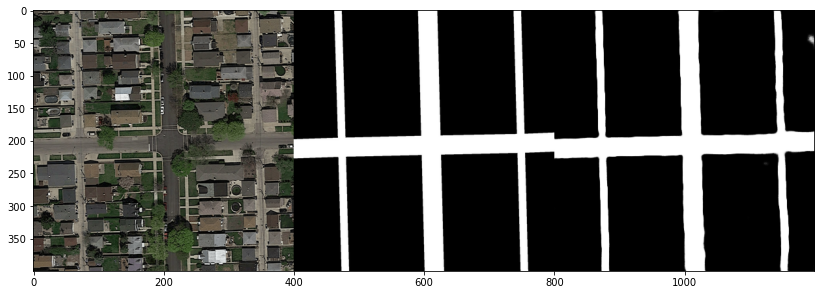

In [12]:
i = 0

files = os.listdir(image_dir)
img = mpimg.imread(image_dir + files[i])
gt = mpimg.imread(gt_dir + files[i])
output = model(torch.tensor(img).to(device).permute(2, 0, 1).view(1, 3, 400, 400))
prediction = output[0][0].cpu().detach().numpy()

from helpers import concatenate_images
fig1 = plt.figure(figsize=(14, 10))
plt.imshow(concatenate_images(concatenate_images(img, gt), prediction))

# **Predict output for testing images**

In [13]:
import image_mask_dataset
submission_dataloader = DataLoader(
    image_mask_dataset.FullSubmissionImageDataset(test_dir),
    batch_size=1
)

In [14]:
from torchvision import transforms
model.eval()
toPIL = transforms.ToPILImage()

output_dir = "outputs"

if output_dir not in os.listdir():
    os.makedirs(output_dir)

for indexes, images in submission_dataloader:
    out = model(images.to(device)).view(2, 608, 608).cpu()
    toPIL(out[0]).save(output_dir + "/file_{:03d}.png".format(indexes.view(-1).item()))

In [31]:
masks_to_submission("submission.csv", *[output_dir + "/" + f for f in os.listdir(output_dir)])